In [2]:
import mlflow
import matplotlib.pyplot as plt
import numpy as np
import os
import json

EXPERIMENT_NAME = "libri-libri-adapt-tuned"
metrics_keys = ["test_loss", "test_wer", "train_loss", "train_wer"]
selection_methods = ["max_kl", "min_kl", "random"]

In [3]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = client.search_runs(experiment.experiment_id)

In [4]:

metrics_means = {}
metrics_stds = {}
metrics_mean_mins = {}
for selection_method in selection_methods:
    metrics_means[selection_method] = {}
    metrics_stds[selection_method] = {}
    metrics_mean_mins[selection_method] = {}
    for metrics_key in metrics_keys:
        values = []
        for run in runs:
            if run.data.params["selection.type"] == selection_method:
                histories = client.get_metric_history(run.info.run_id, metrics_key)
                values_run = []
                for history in histories:
                    values_run.append(history.value)
                values.append(values_run)
        # calculate average for all step
        values = np.array(values)
        print(f"count for {selection_method} and {metrics_key}: {values.shape[0]}")
        means = np.mean(values, axis=0)
        metrics_means[selection_method][metrics_key] = means
        stds = np.std(values, axis=0)
        metrics_stds[selection_method][metrics_key] = stds
        mins = np.min(values, axis=1)
        metrics_mean_mins[selection_method][metrics_key] = np.mean(mins)

count for max_kl and test_loss: 2
count for max_kl and test_wer: 2
count for max_kl and train_loss: 2
count for max_kl and train_wer: 2
count for min_kl and test_loss: 7
count for min_kl and test_wer: 7
count for min_kl and train_loss: 7
count for min_kl and train_wer: 7
count for random and test_loss: 9
count for random and test_wer: 9
count for random and train_loss: 9
count for random and train_wer: 9


In [5]:
metrics_mean_mins

{'max_kl': {'test_loss': 489.2431350187822,
  'test_wer': 0.9959391951560974,
  'train_loss': 2.894508180030166,
  'train_wer': 0.021130324341356754},
 'min_kl': {'test_loss': 610.1976053445608,
  'test_wer': 0.9866086755480085,
  'train_loss': 9.021725206037186,
  'train_wer': 0.06813626763011728},
 'random': {'test_loss': 706.7002932793797,
  'test_wer': 0.9912727342711555,
  'train_loss': 12.815155883595402,
  'train_wer': 0.07088083835939567}}

In [6]:
metrics_mean_mins
SAVE_DIR = f"figs/{EXPERIMENT_NAME}/"
os.makedirs(SAVE_DIR, exist_ok=True)
with open(f"{SAVE_DIR}/mean_min_WER.json", "w") as f:
    json.dump(metrics_mean_mins, f)

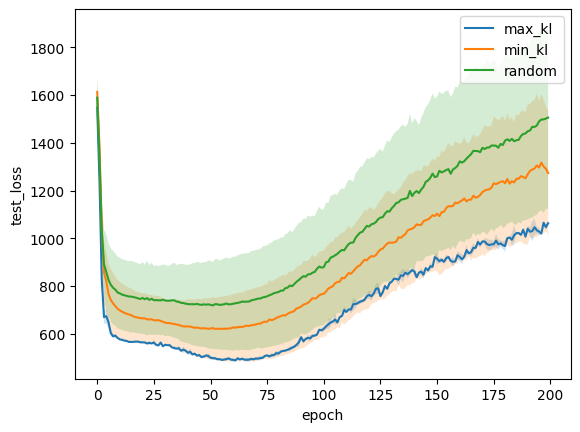

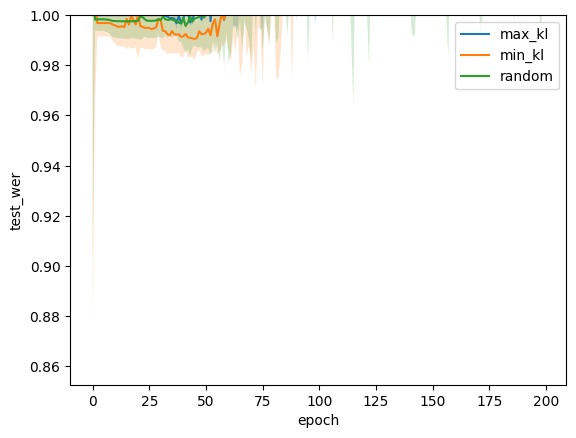

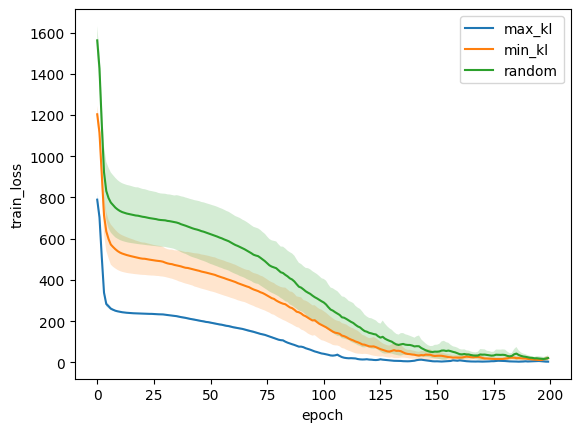

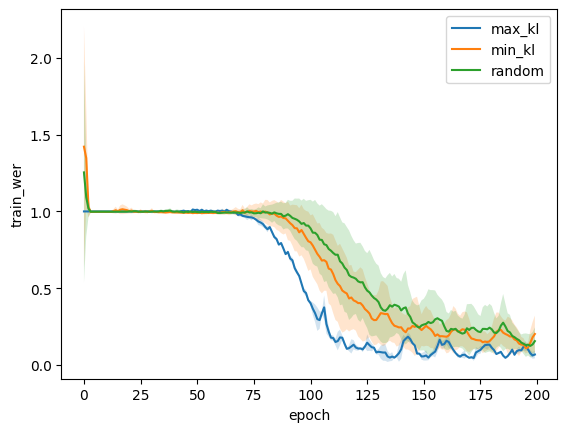

In [7]:
# plot
for metrics_key in metrics_keys:
    fig, ax = plt.subplots()
    for selection_method in selection_methods:
        ax.plot(metrics_means[selection_method][metrics_key], label=selection_method)
        ax.fill_between(
            np.arange(len(metrics_means[selection_method][metrics_key])),
            metrics_means[selection_method][metrics_key] - metrics_stds[selection_method][metrics_key],
            metrics_means[selection_method][metrics_key] + metrics_stds[selection_method][metrics_key],
            alpha=0.2,
        )
    ax.set_xlabel("epoch")
    ax.set_ylabel(metrics_key)
    if metrics_key == "test_wer":
        ax.set_ylim(top=1)
    ax.legend()
    plt.show()
    SAVE_DIR = f"figs/{EXPERIMENT_NAME}/"
    os.makedirs(SAVE_DIR, exist_ok=True)
    fig.savefig(f"{SAVE_DIR}/{metrics_key}.png")